# $\text{Import library}$

In [104]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import polars.selectors as cs
from varname import argname
import pathlib
from pathlib import Path
from PIL import Image
import numpy.linalg as npla
from matplotlib.patches import Ellipse
from tqdm.contrib.concurrent import thread_map

# $\text{Utils functions}$

In [217]:
def get_ellipse_param(anno_path: Path, mode = "xyab") -> list[str | float]:
    """
    - Parameters
        - anno_path: Path (path to the annotation image)

    - Behavior

        Given an annotation image, this function returns the parameters of the ellipse that best fits the annotation.

    - Returns
        - list[str | float]: [file_name, x_center, y_center, width, height, angle]
    """
    anno = Image.open(anno_path)
    pixel_array = np.array(anno.getdata()).reshape(anno.size[1], anno.size[0])
    coords = np.array(np.where(pixel_array))[::-1]
    coef_matrix = np.array(
        [coords[0] ** 2, coords[0] * coords[1], coords[1] ** 2, coords[0], coords[1]],
        dtype=int,
    ).T
    ones_matrix = np.ones_like(coef_matrix[:, 0])
    parameter = npla.lstsq(coef_matrix, ones_matrix, rcond=None)[0]
    A, B, C, D, E, F = parameter.tolist() + [-1]

    a = -np.sqrt(
        2
        * (A * E**2 + C * D**2 - B * D * E + F * (B**2 - 4 * A * C))
        * ((A + C) + np.sqrt((A - C) ** 2 + B**2))
    ) / (B**2 - 4 * A * C)

    b = -np.sqrt(
        2
        * (A * E**2 + C * D**2 - B * D * E + F * (B**2 - 4 * A * C))
        * ((A + C) - np.sqrt((A - C) ** 2 + B**2))
    ) / (B**2 - 4 * A * C)
    # a, b = max(a, b), min(a, b)
    x0 = (2 * C * D - B * E) / (B**2 - 4 * A * C)
    y0 = (2 * A * E - B * D) / (B**2 - 4 * A * C)
    theta = 0.5 * np.arctan2(-B,(C-A)) * 180 / np.pi

    name = anno_path.name.rsplit("_", 1)[0] + ".png"
    if mode == "xyab":
        return [name, x0, y0, a, b, theta]
    elif mode == "abcdef":
        return [name, A, B, C, D, E, F]

In [191]:
def formatting_data(data_path: pathlib.Path, *args, **kwargs) -> pl.DataFrame:
    """
    - Parameters:
        - `data_path`: pathlib.Path (path to the train folder)

    - Behavior:
    
        Create `data` dataframe from image name, image path, `data_pixel` from image name, pixel size
        
        If the data_path is the train folder, it make `data_param` from the annotation path, and join `data` and `data_param` on `image_name` to get the ellipse parameters. Add the annotation path and the head circumference to the `data` dataframe.
        
        Else, it returns a dataframe containing the image name, image path, and the pixel size.

    - Returns:
        `data`: `pl.DataFrame `
        
        (dataframe containing the image aname, image path, annotation path, and the ellipse parameters, the pixel size and the head circumference) if the data_path is the train folder. Else, it returns a dataframe containing the image name, image path, and the pixel size.
        
    """
    data_image = sorted(data_path.glob("./*HC.png"))
    pixel_file = list(data_path.parent.glob(f"{data_path.parts[-1]}*.csv"))[0]

    data_config = {"image_name": [i.name for i in data_image], "image_path": [i.as_posix() for i in data_image]}

    data_schema = {
        "image_name": pl.Utf8,
        "image_path": pl.Utf8,
    }

    data_pixel_schema = {
        "image_name": pl.Utf8,
        "pixel_size": pl.Float64,
    }

    if "train" in data_path.as_posix():
        data_anno = sorted(data_path.glob("./*HC_Annotation.png"))
        data_config["annotation_path"] = [i.as_posix() for i in data_anno]
        data_pixel_schema["head_circumference"] = pl.Float64
        data_schema["annotation_path"] = pl.Utf8

    data = pl.from_dict(data_config, schema=data_schema)

    data_pixel = pl.read_csv(
        pixel_file,
        schema=data_pixel_schema,
    )

    data = data.join(data_pixel, on="image_name")

    column_order = ["image_name", "image_path", "pixel_size"]

    if "train" in data_path.as_posix():
        data = data.with_columns({"annotation_path": data_config["annotation_path"]})
        ellipse_param = thread_map(get_ellipse_param, data_anno)

        data_param = pl.DataFrame(
            {
                "image_name": [i[0] for i in ellipse_param],
                "x_center": [i[1] for i in ellipse_param],
                "y_center": [i[2] for i in ellipse_param],
                "a": [i[3] for i in ellipse_param],
                "b": [i[4] for i in ellipse_param],
                "angle": [i[5] for i in ellipse_param],
            }
        )

        data = data.join(data_param, on="image_name")

        column_order = (
            column_order[:-1]
            + ["annotation_path", "x_center", "y_center", "a", "b", "angle"]
            + column_order[-1:]
            + ["head_circumference"]
        )

    data = data.select(column_order)
    return data

In [302]:
def write_obb(anno_path: str, label_path:Path) -> list[int]:
    """
    - Parameters
        - anno_path: Path (path to the annotation image)
        - label_path: Path (path to the label directory)

    - Behavior

        Given an annotation image, this function returns the highest, lowest, rightmost, leftmost points of the annotation.
        
        class: 0:head
        x1, y1: highest point
        x2, y2: rightmost point
        x3, y3: lowest point
        x4, y4: leftmost point 
        
    - Returns
        - list[int]: [class, x1, y1, x2, y2, x3, y3, x4, y4]
    """
    anno_path = Path(anno_path)
    label_path.mkdir(parents=True, exist_ok=True)
    anno = Image.open(anno_path)
    pixel_array = np.array(anno.getdata()).reshape(anno.size[1], anno.size[0])
    coords = np.array(np.where(pixel_array))[::-1]
    x1, y1 = coords[:, coords[1].argmin()]/pixel_array.T.shape
    x2, y2 = coords[:, coords[0].argmax()]/pixel_array.T.shape
    x3, y3 = coords[:, coords[1].argmax()]/pixel_array.T.shape
    x4, y4 = coords[:, coords[0].argmin()]/pixel_array.T.shape
    with open(label_path/anno_path.name.replace("_Annotation.png", ".txt"), "w") as f:
        f.write(f"0 {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}")

In [197]:
def plot_sample_data(data: pl.DataFrame, *args, **kwargs) -> None:
    """
    - Parameters:
        - `data`: pl.DataFrame (dataframe containing the image aname, image path, annotation path, and the ellipse parameters, the pixel size and the head circumference)
    
    - Behavior:
    
        Plot some sample images with their corresponding ellipse annotation.
        
    - Returns:
        None
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        image = Image.open(data["image_path"][i])
        ax.imshow(image, cmap="gray")
        ellipse = Ellipse(
            (data["x_center"][i], data["y_center"][i]),
            data["a"][i]*2,
            data["b"][i]*2,
            angle = data["angle"][i],
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(ellipse)
        ax.set_title(data["image_name"][i])
    plt.show()

In [198]:
def plot_data(data: pl.DataFrame, *args, **kwargs) -> None:
    plot_sample_data(data)

# $\text{Reads and Analyze data}$

In [218]:
data_path_train: pathlib.Path = Path("../../data/images/training_set")
data_train: pl.DataFrame = formatting_data(data_path_train)
data_train.head()

  0%|          | 0/999 [00:00<?, ?it/s]

image_name,image_path,annotation_path,x_center,y_center,a,b,angle,pixel_size,head_circumference
str,str,str,f64,f64,f64,f64,f64,f64,f64
"""000_HC.png""","""../../data/ima…","""../../data/ima…",409.4485,377.758048,92.747865,110.833947,23.82478,0.069136,44.3
"""001_HC.png""","""../../data/ima…","""../../data/ima…",402.619652,221.663989,87.9039,113.025743,80.961883,0.089659,56.81
"""002_HC.png""","""../../data/ima…","""../../data/ima…",283.938429,192.083759,160.189005,191.851056,-24.310829,0.062033,68.75
"""003_HC.png""","""../../data/ima…","""../../data/ima…",415.844392,357.70504,109.819552,130.355549,-88.828896,0.091291,69.0
"""004_HC.png""","""../../data/ima…","""../../data/ima…",338.329372,292.719812,138.759372,171.265286,-48.37968,0.06124,59.81
"""005_HC.png""","""../../data/ima…","""../../data/ima…",322.741444,237.24257,87.455013,104.013686,62.080472,0.115814,69.8
"""006_HC.png""","""../../data/ima…","""../../data/ima…",430.210711,246.026216,150.086174,178.4532,-10.762481,0.065606,67.84
"""007_HC.png""","""../../data/ima…","""../../data/ima…",446.665495,370.767439,83.908736,98.600281,56.851144,0.109362,62.8
"""008_HC.png""","""../../data/ima…","""../../data/ima…",377.010202,334.452373,113.933699,139.925606,-72.75286,0.077655,62.1


In [219]:
data_path_test = Path("../../data/images/test_set")
data_test: pl.DataFrame = formatting_data(data_path_test)
data_test.head()

image_name,image_path,pixel_size
str,str,f64
"""000_HC.png""","""../../data/ima…",0.235857
"""001_HC.png""","""../../data/ima…",0.067973
"""002_HC.png""","""../../data/ima…",0.165202
"""003_HC.png""","""../../data/ima…",0.096674
"""004_HC.png""","""../../data/ima…",0.202203
"""005_HC.png""","""../../data/ima…",0.116687
"""006_HC.png""","""../../data/ima…",0.13981
"""007_HC.png""","""../../data/ima…",0.141644
"""008_HC.png""","""../../data/ima…",0.153438


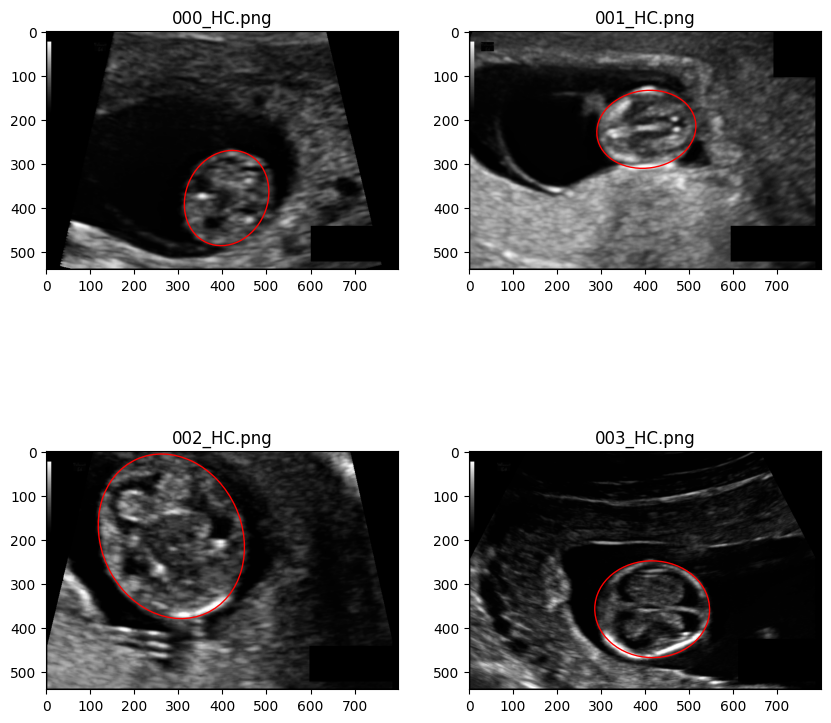

In [236]:
plot_sample_data(data_train)

# $\text{Make OBB labels}$

In [303]:
print("Making OBB for training set")
images_paths = data_train["annotation_path"].to_list()
label_dir = [Path("../../data/labels/training_set") for i in range(len(images_paths))]
_ = thread_map(write_obb, images_paths, label_dir)

  0%|          | 0/999 [00:00<?, ?it/s]